In [ ]:
pip install downcast

In [ ]:
pip install catboost 

     |████████████████████████████████| 67.3MB 75kB/s 


In [ ]:
import pandas as pd
import pickle
import numpy as np
from downcast import reduce
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
import random 
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def rmse(pred,value):
    return np.sqrt(((pred-value)**2).mean())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
calendar_=pd.read_csv('/content/drive//My Drive/CS-1/calendar.csv')
sales_train_eval=pd.read_csv('/content/drive//My Drive/CS-1/sales_train_evaluation.csv')
sell_prices_=pd.read_csv('/content/drive//My Drive/CS-1/sell_prices.csv')

In [ ]:
calendar_=reduce(calendar_)
sales_train_eval=reduce(sales_train_eval)
sell_prices_=reduce(sell_prices_)

In [ ]:
#https://pandas.pydata.org/docs/reference/api/pandas.melt.html
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
ma_df=pd.melt(sales_train_eval,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],var_name='d',value_name='demand')
ma_df=pd.merge(ma_df,calendar_,on='d',how='left')
ma_df=pd.merge(ma_df,sell_prices_,on=['item_id','store_id','wm_yr_wk'],how='left')

In [ ]:
ma_df=reduce(ma_df)

In [ ]:
ma_df.shape

(59181090, 22)

In [ ]:
l=[]
for i in ma_df['d']:
  l.append(i.split('_')[1])
ma_df['day']=l
ma_df['day']=ma_df['day'].astype(np.int16) 
ma_df=ma_df.drop(['d'],axis=1)

In [ ]:
ma_df.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,1


# Moving - Average

* Divide data into Train/Test

  * Train: Till d_1913

  * Test: From d_1914 to d_1941

In [ ]:
#https://www.kite.com/python/answers/how-to-select-rows-by-multiple-label-conditions-with-pandas-loc-in-python
train=ma_df.loc[ma_df['day']<1914]
test=ma_df.loc[ma_df['day']>=1914]
print("train {}".format(train.shape))
print("\ntest {}".format(test.shape))

train (58327370, 22)

test (853720, 22)


In [ ]:
#https://www.youtube.com/watch?v=WlHgUtrGalI
#https://www.kite.com/python/answers/how-to-find-the-moving-average-of-a-list-in-python
def moving_avg(data,window_size):
  values=pd.Series(data)
  windows=values.rolling(window_size)
  moving_averages=windows.mean()
  #No. of NaN values will be equal to window_size we take .Thats why I replaced 'NaN' with '0'
  moving_averages=moving_averages.fillna(0) 
  moving_averages=moving_averages.tolist()
  print("Window Size:",window_size,"  ","RMSE:",rmse(moving_averages,values))
  print("-"*150)
  return moving_averages

In [ ]:
y_hat=[]
window=[7,14,21,28,35,42,49,60,70,80,90]
for i in window:
  y_hat=moving_avg(train['demand'].tolist(),i)

Window Size: 7    RMSE: 3.511718482719169
------------------------------------------------------------------------------------------------------------------------------------------------------
Window Size: 14    RMSE: 3.6431494112322866
------------------------------------------------------------------------------------------------------------------------------------------------------
Window Size: 21    RMSE: 3.691492799545559
------------------------------------------------------------------------------------------------------------------------------------------------------
Window Size: 28    RMSE: 3.7150190970587063
------------------------------------------------------------------------------------------------------------------------------------------------------
Window Size: 35    RMSE: 3.724464936750333
------------------------------------------------------------------------------------------------------------------------------------------------------
Window Size: 42    RMSE: 3.73

In [ ]:
y_hat=moving_avg(test['demand'].tolist(),7)
test['pred_demand']=y_hat

Window Size: 7    RMSE: 3.2802351235019738
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
s1=pd.DataFrame()
s2=pd.DataFrame()
#test dataset(from 1914 to 1941 days) present in sales_train_evaluation only thats why sales_train_evaluation choosen
s1['id']=sales_train_eval['id'] 
j=1
for i in range(1914,1942):
  s1['F'+str(j)]=test[test['day']==i]['pred_demand'].values
  j+=1
s1["id"]=s1["id"].apply(lambda x: x.replace('evaluation','validation'))
s2=s1.copy()
s2["id"]=s1["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_Moving_Avg_=pd.concat([s1,s2]).reset_index().drop(['index'],axis=1)

In [ ]:
submit_Moving_Avg_.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0,0.142857,0.857143,0.857143,1.000000,1.285714,2.000000,1.000000,1.142857,1.285714,0.714286,1.000000,0.857143,1.142857,1.000000,0.571429,0.857143,0.857143,0.857143,1.142857,0.714286,1.428571,2.000000,1.857143,0.714286,1.285714,0.714286,1.714286
1,HOBBIES_1_002_CA_1_validation,0.0,0.285714,0.571429,0.571429,0.714286,1.000000,1.285714,0.285714,0.571429,1.142857,0.285714,0.857143,0.857143,0.857143,0.857143,0.571429,0.571429,0.857143,0.571429,1.142857,0.714286,0.857143,1.714286,1.571429,0.714286,1.000000,0.571429,1.285714
2,HOBBIES_1_003_CA_1_validation,0.0,0.285714,0.714286,0.714286,0.428571,1.000000,1.428571,0.285714,0.571429,0.857143,0.285714,1.142857,0.857143,1.142857,0.714286,0.571429,0.714286,0.714286,0.714286,1.000000,1.000000,0.428571,1.714286,1.428571,0.857143,1.428571,0.571429,1.285714
3,HOBBIES_1_004_CA_1_validation,0.0,0.285714,0.714286,0.857143,0.857143,1.142857,2.285714,0.857143,0.571429,0.714286,0.285714,1.142857,1.142857,1.714286,1.000000,0.714286,0.857143,0.857143,0.857143,1.142857,1.000000,1.000000,1.714286,1.571429,1.285714,1.285714,0.857143,2.000000
4,HOBBIES_1_005_CA_1_validation,0.0,0.285714,1.000000,1.142857,0.857143,1.142857,2.428571,1.000000,0.857143,0.857143,0.428571,1.428571,1.428571,2.142857,1.142857,1.000000,0.714286,0.714286,0.714286,1.142857,1.000000,1.142857,1.571429,1.571429,1.142857,1.571429,0.857143,2.000000


In [ ]:
submit_Moving_Avg_.to_csv("/content/drive//My Drive/CS-1/submit_Moving_Avg_.csv",index=False)

# ML Models

In [ ]:
with open('/content/drive//My Drive/CS-1/data_final.pkl','rb') as f:
     data_final=pickle.load(f)

In [ ]:
data_final.shape

(59181090, 36)

* Taken data after 1000 days (d_1000) so that processing speed will be fast (last approx. 31 months data)

In [ ]:
df=data_final[data_final['day']>1000]

In [ ]:
df.shape

(28691090, 36)

* Divide data into Train/Test/Validation 

  * Train: Till d_1885

  * Validation: From d_1886 to d_1914

  * Test: From d_1914 to d_1941

In [ ]:
l=[]
for i in range(1886,1914):
  l.append(i)

#https://www.kite.com/python/answers/how-to-select-rows-by-multiple-label-conditions-with-pandas-loc-in-python
x_train=df.loc[df['day']<=1885]
x_valid=df.loc[df['day'].isin(l)]
x_test=df.loc[df['day']>=1914]

y_train=x_train['demand']
y_valid=x_valid['demand']
y_test=x_test['demand']

x_train=x_train.drop(['demand'],axis=1)
x_valid=x_valid.drop(['demand'],axis=1)
x_test=x_test.drop(['demand'],axis=1)

print("x_train {}".format(x_train.shape),"  y_train {}".format(y_train.shape))
print("\nx_valid {}".format(x_valid.shape),"  y_valid {}".format(y_valid.shape))
print("\nx_test {}".format(x_test.shape),"  y_test {}".format(y_test.shape))

x_train (26983650, 35)   y_train (26983650,)

x_valid (853720, 35)   y_valid (853720,)

x_test (853720, 35)   y_test (853720,)


# 1. Linear-Regression

In [ ]:
lr=LinearRegression(n_jobs=-1)
lr.fit(x_train,y_train)
y_pred=lr.predict(x_valid)
print("Rmse: {}".format(rmse(y_pred,y_valid)))

Rmse: 1.8829733119051815


In [ ]:
with open('/content/drive//My Drive/CS-1/Linear_Regression_model.pkl','wb') as f:
     pickle.dump(lr,f)

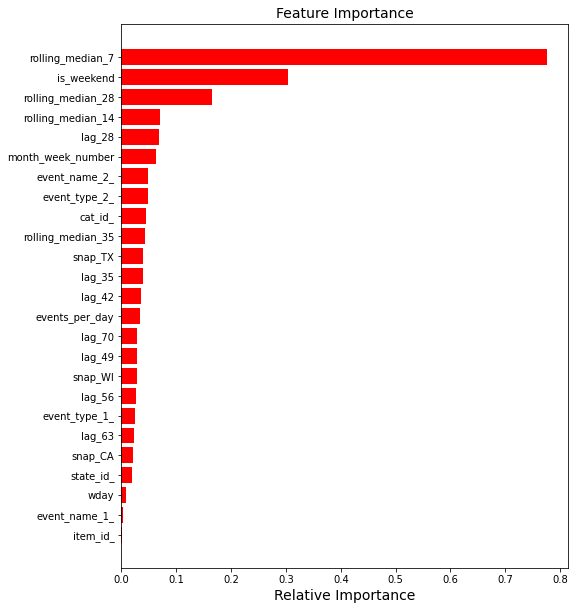

In [ ]:
features=x_train.columns
imp=lr.coef_
indices=(np.argsort(imp))[10:]
plt.figure(figsize=(8,10))
plt.title('Feature Importance',fontsize=14)
plt.barh(range(len(indices)),imp[indices],color='r')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

In [ ]:
s1=pd.DataFrame()
s2=pd.DataFrame()
#test dataset(from 1914 to 1941 days) present in sales_train_evaluation only thats why sales_train_evaluation choosen
s1['id']=sales_train_eval['id'] 
j=1
for i in range(1914,1942):
  s1['F'+str(j)]=lr.predict(x_test[x_test['day']==(i)]) 
  j+=1
s1["id"]=s1["id"].apply(lambda x: x.replace('evaluation','validation'))
s2=s1.copy()
s2["id"]=s1["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_Linear_Regression_=pd.concat([s1,s2]).reset_index().drop(['index'],axis=1)

In [ ]:
submit_Linear_Regression_.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.030670,0.996658,0.218948,0.171158,0.420731,0.538956,0.696228,0.333252,0.559723,1.139938,1.049438,1.164246,1.380295,1.447098,1.014771,1.180206,1.110550,1.188095,1.941208,2.201202,2.253265,0.979187,0.361481,0.319122,0.475586,0.330002,0.588562,0.640335
1,HOBBIES_1_002_CA_1_validation,0.194977,0.126038,0.095032,0.209259,0.193542,0.453720,0.519089,0.247787,0.220642,0.151337,0.181839,0.250107,0.493362,0.428726,0.273956,0.147263,0.191940,0.270325,0.189011,0.444885,0.552338,0.179855,0.895660,0.961746,0.947052,0.916061,0.415207,0.447083
2,HOBBIES_1_003_CA_1_validation,0.983109,1.009781,1.062881,1.114502,1.278931,1.600616,1.626694,1.229828,1.293533,0.362045,0.348022,0.531403,0.881287,0.711685,0.491882,0.445114,1.150986,1.220993,1.104767,0.631577,0.660645,0.162872,0.107620,0.004028,0.126373,0.205902,0.300674,0.403656
3,HOBBIES_1_004_CA_1_validation,1.126480,0.822845,0.905930,2.017014,2.094086,1.820801,2.051682,2.223053,2.043182,2.047531,1.300873,1.560852,2.834000,3.006561,2.256821,1.922379,2.069839,1.927612,1.287521,1.671875,2.221207,1.538162,1.120667,1.143845,1.153946,1.375854,2.040085,2.733490
4,HOBBIES_1_005_CA_1_validation,2.021744,1.953735,2.089996,2.033432,1.932770,1.361786,1.759750,2.059250,2.128922,2.056381,1.242966,2.043671,2.310654,2.427109,2.289032,2.180328,2.307053,2.280609,2.285049,2.483032,2.659256,2.227951,1.420761,0.710312,0.733749,0.777557,1.706009,1.870361


In [ ]:
submit_Linear_Regression_.to_csv("/content/drive//My Drive/CS-1/submit_Linear_Regression_.csv",index=False)

# 2. Decision Trees

* Hyperparameter - Tunning

In [ ]:
for i in tqdm(range(10)): 
  max_depth=random.randint(1,200)
  min_samples_split=random.randint(10,600)
  min_samples_leaf=random.randint(20,500)
  dt=DecisionTreeRegressor(max_depth=max_depth,min_samples_split=min_samples_split,max_leaf_nodes=min_samples_leaf)
  dt.fit(x_train,y_train)
  y_pred=dt.predict(x_valid)
  print("\n\nmax_depth: {}".format(max_depth),"  min_samples_split: {}".format(min_samples_split),"  min_samples_leaf: {}".format(min_samples_leaf),"  Rmse: {}".format(rmse(y_pred,y_valid)))
  print("-"*150)

 10%|█         | 1/10 [06:04<54:43, 364.81s/it]



max_depth: 74   min_samples_split: 486   min_samples_leaf: 198   Rmse: 1.8729889899005463
------------------------------------------------------------------------------------------------------------------------------------------------------


 20%|██        | 2/10 [11:36<47:19, 354.91s/it]



max_depth: 152   min_samples_split: 54   min_samples_leaf: 155   Rmse: 1.8788562331050065
------------------------------------------------------------------------------------------------------------------------------------------------------


 30%|███       | 3/10 [17:12<40:45, 349.33s/it]



max_depth: 57   min_samples_split: 214   min_samples_leaf: 128   Rmse: 1.8778773396150683
------------------------------------------------------------------------------------------------------------------------------------------------------


 40%|████      | 4/10 [22:59<34:51, 348.52s/it]



max_depth: 107   min_samples_split: 106   min_samples_leaf: 185   Rmse: 1.8813321915874566
------------------------------------------------------------------------------------------------------------------------------------------------------


 50%|█████     | 5/10 [29:41<30:22, 364.49s/it]



max_depth: 104   min_samples_split: 278   min_samples_leaf: 344   Rmse: 1.8667355819894134
------------------------------------------------------------------------------------------------------------------------------------------------------


 60%|██████    | 6/10 [35:54<24:28, 367.01s/it]



max_depth: 139   min_samples_split: 220   min_samples_leaf: 248   Rmse: 1.8739282768231444
------------------------------------------------------------------------------------------------------------------------------------------------------


 70%|███████   | 7/10 [42:07<18:26, 368.81s/it]



max_depth: 156   min_samples_split: 375   min_samples_leaf: 244   Rmse: 1.8687871024501579
------------------------------------------------------------------------------------------------------------------------------------------------------


 80%|████████  | 8/10 [48:57<12:42, 381.12s/it]



max_depth: 161   min_samples_split: 389   min_samples_leaf: 453   Rmse: 1.873085282237073
------------------------------------------------------------------------------------------------------------------------------------------------------


 90%|█████████ | 9/10 [54:44<06:11, 371.01s/it]



max_depth: 58   min_samples_split: 377   min_samples_leaf: 266   Rmse: 1.8687998569789253
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [1:00:56<00:00, 365.68s/it]



max_depth: 175   min_samples_split: 100   min_samples_leaf: 481   Rmse: 1.8847818381951496
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
max_depth=104
min_samples_split=278
min_samples_leaf=344 
dt=DecisionTreeRegressor(max_depth=max_depth,min_samples_split=min_samples_split,max_leaf_nodes=min_samples_leaf)
dt.fit(x_train,y_train)
y_pred=dt.predict(x_valid)
print("max_depth: {}".format(max_depth),"  min_samples_split: {}".format(min_samples_split),"  min_samples_leaf: {}".format(min_samples_leaf),"  Rmse: {}".format(rmse(y_pred,y_valid)))

max_depth: 104   min_samples_split: 278   min_samples_leaf: 344   Rmse: 1.8667355819894134


In [ ]:
with open('/content/drive//My Drive/CS-1/decision_tree_model.pkl','wb') as f:
     pickle.dump(dt,f)

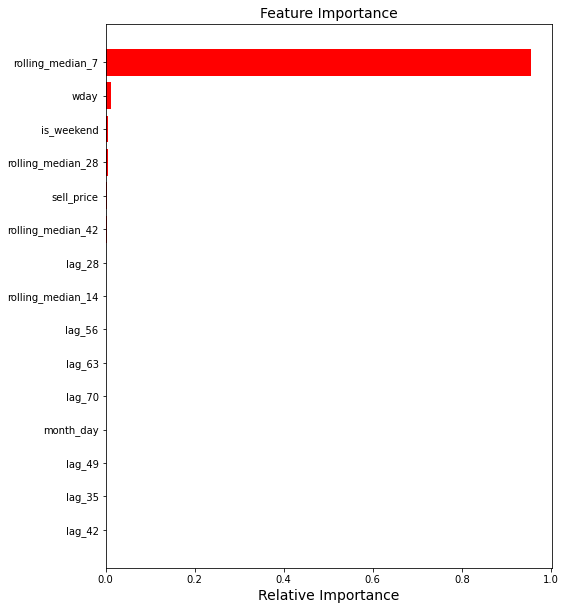

In [ ]:
features=x_train.columns
imp=dt.feature_importances_
indices=(np.argsort(imp))[20:]
plt.figure(figsize=(8,10))
plt.title('Feature Importance',fontsize=14)
plt.barh(range(len(indices)),imp[indices],color='r')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

In [ ]:
s1=pd.DataFrame()
s2=pd.DataFrame()
#test dataset(from 1914 to 1941 days) present in sales_train_evaluation only thats why sales_train_evaluation choosen
s1['id']=sales_train_eval['id'] 
j=1
for i in range(1914,1942):
  s1['F'+str(j)]=dt.predict(x_test[x_test['day']==(i)]) 
  j+=1
s1["id"]=s1["id"].apply(lambda x: x.replace('evaluation','validation'))
s2=s1.copy()
s2["id"]=s1["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_DecisionTree_Regressor_=pd.concat([s1,s2]).reset_index().drop(['index'],axis=1)

In [ ]:
submit_DecisionTree_Regressor_.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.048379,1.048379,0.580245,0.580245,0.580245,0.851691,0.851691,0.580245,0.580245,0.867724,0.867724,0.867724,1.410082,1.410082,1.048379,1.048379,1.048379,1.048379,1.809639,2.302511,2.302511,1.048379,0.580245,0.580245,0.580245,0.580245,0.851691,0.851691
1,HOBBIES_1_002_CA_1_validation,0.314857,0.128793,0.128793,0.296296,0.296296,0.296296,0.296296,0.296296,0.128793,0.128793,0.264450,0.264450,0.264450,0.264450,0.264450,0.128793,0.128793,0.236785,0.236785,0.236785,0.236785,0.236785,0.867724,0.867724,0.867724,0.867724,0.128793,0.128793
2,HOBBIES_1_003_CA_1_validation,1.048379,1.048379,1.048379,1.048379,1.048379,1.410082,1.410082,1.048379,1.048379,0.580245,0.580245,0.580245,0.851691,0.851691,0.580245,0.580245,0.867724,0.867724,0.867724,0.851691,0.851691,0.580245,0.580245,0.522096,0.580245,0.580245,0.522096,0.522096
3,HOBBIES_1_004_CA_1_validation,1.411044,1.411044,1.411044,1.809639,1.809639,1.887662,2.034089,1.809639,1.809639,1.809639,1.378306,1.378306,2.672851,2.672851,2.034848,2.034848,2.034848,2.034848,1.048379,1.410082,1.410082,1.048379,1.048379,1.048379,1.048379,1.048379,1.410082,2.302511
4,HOBBIES_1_005_CA_1_validation,1.809639,1.809639,1.809639,1.809639,1.809639,1.410082,1.887662,1.809639,1.809639,1.809639,1.378306,1.809639,2.302511,2.302511,1.809639,1.809639,1.809639,2.034848,2.034848,2.672851,2.672851,2.034848,1.378306,0.951921,0.951921,0.951921,1.887662,1.410082


In [ ]:
submit_DecisionTree_Regressor_.to_csv("/content/drive//My Drive/CS-1/submit_DecisionTree_Regressor_.csv",index=False)

# 3. Random-Forest

* Hyperparameter - Tunning

In [ ]:
for i in tqdm(range(10)):
   max_depth=np.random.randint(1,10)
   min_samples_leaf=np.random.randint(2,8)
   n_estimators=np.random.randint(50,100)
   rf=RandomForestRegressor(max_depth=max_depth,min_samples_leaf=min_samples_leaf,n_estimators=n_estimators,n_jobs=-1)
   rf.fit(x_train,y_train)
   y_pred=rf.predict(x_valid)
   print("\n\nmax_depth: {}".format(max_depth),"  min_samples_leaf: {}".format(min_samples_leaf),"  n_estimators: {}".format(n_estimators),"  Rmse: {}".format(rmse(y_pred,y_valid)))
   print("-"*150)

 10%|█         | 1/10 [47:27<7:07:04, 2847.13s/it]



max_depth: 4   min_samples_leaf: 7   n_estimators: 61   Rmse: 1.957338299244596
------------------------------------------------------------------------------------------------------------------------------------------------------


 20%|██        | 2/10 [2:12:00<7:48:39, 3514.91s/it]



max_depth: 9   min_samples_leaf: 2   n_estimators: 52   Rmse: 1.8523079856359335
------------------------------------------------------------------------------------------------------------------------------------------------------


 30%|███       | 3/10 [3:57:37<8:28:52, 4361.75s/it]



max_depth: 8   min_samples_leaf: 3   n_estimators: 73   Rmse: 1.856895068487145
------------------------------------------------------------------------------------------------------------------------------------------------------


 40%|████      | 4/10 [4:56:33<6:51:23, 4113.94s/it]



max_depth: 4   min_samples_leaf: 7   n_estimators: 78   Rmse: 1.9575048428272526
------------------------------------------------------------------------------------------------------------------------------------------------------


 50%|█████     | 5/10 [6:11:15<5:52:02, 4224.44s/it]



max_depth: 7   min_samples_leaf: 5   n_estimators: 58   Rmse: 1.8641241144217795
------------------------------------------------------------------------------------------------------------------------------------------------------


 60%|██████    | 6/10 [8:16:19<5:47:12, 5208.11s/it]



max_depth: 9   min_samples_leaf: 2   n_estimators: 77   Rmse: 1.8510883320792824
------------------------------------------------------------------------------------------------------------------------------------------------------


 70%|███████   | 7/10 [10:18:40<4:52:24, 5848.15s/it]



max_depth: 7   min_samples_leaf: 7   n_estimators: 99   Rmse: 1.8639368871108983
------------------------------------------------------------------------------------------------------------------------------------------------------


 80%|████████  | 8/10 [11:23:30<2:55:21, 5260.69s/it]



max_depth: 6   min_samples_leaf: 6   n_estimators: 62   Rmse: 1.8789090854483286
------------------------------------------------------------------------------------------------------------------------------------------------------


 90%|█████████ | 9/10 [11:43:27<1:07:21, 4041.53s/it]



max_depth: 2   min_samples_leaf: 7   n_estimators: 55   Rmse: 2.266820221080764
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [12:58:08<00:00, 4668.81s/it]



max_depth: 8   min_samples_leaf: 5   n_estimators: 53   Rmse: 1.8562092610482945
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
max_depth=9
min_samples_leaf=2
n_estimators=77
rf=RandomForestRegressor(max_depth=max_depth,min_samples_leaf=min_samples_leaf,n_estimators=n_estimators,n_jobs=-1)
rf.fit(x_train,y_train)
y_pred=rf.predict(x_valid)
print("max_depth: {}".format(max_depth),"  min_samples_leaf: {}".format(min_samples_leaf),"  n_estimators: {}".format(n_estimators),"  Rmse: {}".format(rmse(y_pred,y_valid)))

max_depth: 9   min_samples_leaf: 2   n_estimators: 77   Rmse: 1.8512297911517372


In [ ]:
with open('/content/drive//My Drive/CS-1/RandomForest_model.pkl','wb') as f:
     pickle.dump(rf,f)

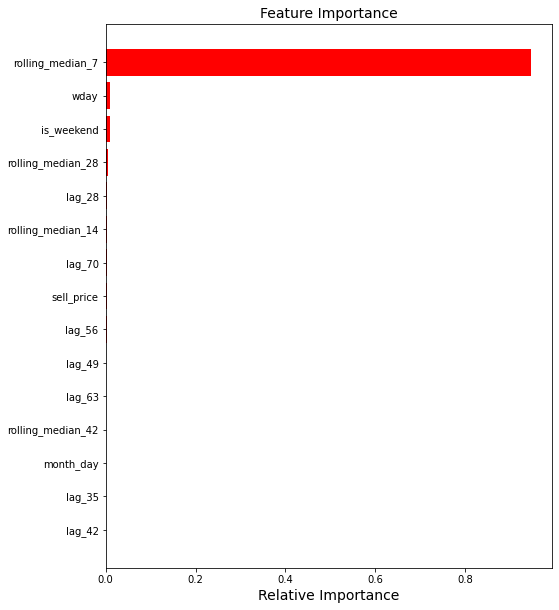

In [ ]:
features=x_train.columns
imp=rf.feature_importances_
indices=(np.argsort(imp))[20:]
plt.figure(figsize=(8,10))
plt.title('Feature Importance',fontsize=14)
plt.barh(range(len(indices)),imp[indices],color='r')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

In [ ]:
s1=pd.DataFrame()
s2=pd.DataFrame()
#test dataset(from 1914 to 1941 days) present in sales_train_evaluation only thats why sales_train_evaluation choosen
s1['id']=sales_train_eval['id'] 
j=1
for i in range(1914,1942):
  s1['F'+str(j)]=rf.predict(x_test[x_test['day']==(i)]) 
  j+=1
s1["id"]=s1["id"].apply(lambda x: x.replace('evaluation','validation'))
s2=s1.copy()
s2["id"]=s1["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_RandomForest_Regressor_=pd.concat([s1,s2]).reset_index().drop(['index'],axis=1)

In [ ]:
submit_RandomForest_Regressor_.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.066847,1.066847,0.597574,0.597574,0.597574,0.861684,0.861684,0.597574,0.597574,0.882470,0.882470,0.882470,1.420808,1.420808,1.066847,1.066847,1.066847,1.066847,1.774074,2.288096,2.288096,1.066847,0.597574,0.597574,0.597574,0.609657,0.861684,0.861684
1,HOBBIES_1_002_CA_1_validation,0.309808,0.151347,0.151347,0.318232,0.318232,0.318232,0.318232,0.318232,0.151347,0.151347,0.195260,0.195260,0.195260,0.195260,0.195260,0.151347,0.151347,0.151347,0.151347,0.151347,0.151347,0.151347,0.856734,0.856734,0.856734,0.856734,0.151347,0.151347
2,HOBBIES_1_003_CA_1_validation,1.042853,1.042853,1.042853,1.064055,1.064055,1.317903,1.317903,1.064055,1.064055,0.597574,0.597574,0.597574,0.861684,0.861684,0.597574,0.597574,0.877936,0.877936,0.880728,0.859352,0.859352,0.597574,0.597574,0.327761,0.597574,0.597574,0.327761,0.327761
3,HOBBIES_1_004_CA_1_validation,1.340847,1.340847,1.340847,1.774074,1.774074,1.925234,2.098713,1.774074,1.774074,1.774074,1.376763,1.376763,2.592803,2.575995,2.008795,2.008795,2.008795,1.918269,1.066847,1.420808,1.437286,1.066847,1.066847,1.066847,1.066847,1.066847,1.437286,2.288096
4,HOBBIES_1_005_CA_1_validation,1.774074,1.774074,1.774074,1.774074,1.774074,1.420808,1.773776,1.868163,1.868163,1.864600,1.308102,1.864600,2.343839,2.362401,1.864600,1.864600,1.864600,2.008795,2.008795,2.601121,2.601121,2.008795,1.376763,0.769293,0.769293,0.769293,1.925234,1.659819


In [ ]:
submit_RandomForest_Regressor_.to_csv("/content/drive//My Drive/CS-1/submit_RandomForest_Regressor_.csv",index=False)

#4. XGBoost 

In [ ]:
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://xgboost.readthedocs.io/en/latest/gpu/index.html
for i in tqdm(range(10)):
  #https://pynative.com/python-get-random-float-numbers
  learning_rate=np.round(np.random.uniform(0.001,0.05),4)
  max_leaves=np.random.randint(20,150)
  min_child_weight=random.randint(20,100) 
  xgb=XGBRegressor(learning_rate=learning_rate,max_leaves=max_leaves,min_child_weight=min_child_weight,subsample=0.7,colsample_bytree=0.7,tree_method='gpu_hist',gpu_id=0,grow_policy='lossguide',n_estimators=100,objective='reg:squarederror',booster='gbtree',n_jobs=-1)
  xgb.fit(x_train,y_train)
  y_pred=xgb.predict(x_valid)
  print("\n\nlearning_rate: {}".format(learning_rate),"  max_leaves: {}".format(max_leaves),"  min_child_weight: {}".format(min_child_weight),"  Rmse: {}".format(rmse(y_pred,y_valid)))
  print("-"*150)

 10%|█         | 1/10 [00:51<07:47, 51.99s/it]



learning_rate: 0.0329   max_leaves: 72   min_child_weight: 82   Rmse: 1.8703247911245373
------------------------------------------------------------------------------------------------------------------------------------------------------


 20%|██        | 2/10 [01:37<06:40, 50.06s/it]



learning_rate: 0.004   max_leaves: 78   min_child_weight: 84   Rmse: 2.8994043593535013
------------------------------------------------------------------------------------------------------------------------------------------------------


 30%|███       | 3/10 [02:23<05:40, 48.69s/it]



learning_rate: 0.0315   max_leaves: 65   min_child_weight: 82   Rmse: 1.8744039859800985
------------------------------------------------------------------------------------------------------------------------------------------------------


 40%|████      | 4/10 [03:08<04:47, 47.86s/it]



learning_rate: 0.0195   max_leaves: 145   min_child_weight: 100   Rmse: 1.958431877199985
------------------------------------------------------------------------------------------------------------------------------------------------------


 50%|█████     | 5/10 [03:54<03:56, 47.21s/it]



learning_rate: 0.0255   max_leaves: 107   min_child_weight: 96   Rmse: 1.9008214605290366
------------------------------------------------------------------------------------------------------------------------------------------------------


 60%|██████    | 6/10 [04:40<03:06, 46.67s/it]



learning_rate: 0.0483   max_leaves: 47   min_child_weight: 100   Rmse: 1.8507495495781356
------------------------------------------------------------------------------------------------------------------------------------------------------


 70%|███████   | 7/10 [05:25<02:18, 46.22s/it]



learning_rate: 0.0438   max_leaves: 57   min_child_weight: 48   Rmse: 1.8533741260860197
------------------------------------------------------------------------------------------------------------------------------------------------------


 80%|████████  | 8/10 [06:10<01:31, 45.96s/it]



learning_rate: 0.0416   max_leaves: 116   min_child_weight: 92   Rmse: 1.8561686591106028
------------------------------------------------------------------------------------------------------------------------------------------------------


 90%|█████████ | 9/10 [06:56<00:45, 45.86s/it]



learning_rate: 0.0232   max_leaves: 113   min_child_weight: 78   Rmse: 1.916935970902661
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [07:41<00:00, 46.19s/it]



learning_rate: 0.0122   max_leaves: 78   min_child_weight: 34   Rmse: 2.16146275776483
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
learning_rate=0.0483
max_leaves=47
min_child_weight=100
xgb=XGBRegressor(learning_rate=learning_rate,max_leaves=max_leaves,min_child_weight=min_child_weight,subsample=0.7,colsample_bytree=0.7,tree_method='gpu_hist',gpu_id=0,grow_policy='lossguide',n_estimators=100,objective='reg:squarederror',booster='gbtree',n_jobs=-1)
xgb.fit(x_train,y_train)
y_pred=xgb.predict(x_valid)
print("learning_rate: {}".format(learning_rate),"  max_leaves: {}".format(max_leaves),"  min_child_weight: {}".format(min_child_weight),"  Rmse: {}".format(rmse(y_pred,y_valid)))

learning_rate: 0.0483   max_leaves: 47   min_child_weight: 100   Rmse: 1.8507495495781356


In [ ]:
with open('/content/drive//My Drive/CS-1/XGBoost_model.pkl','wb') as f:
     pickle.dump(xgb,f)

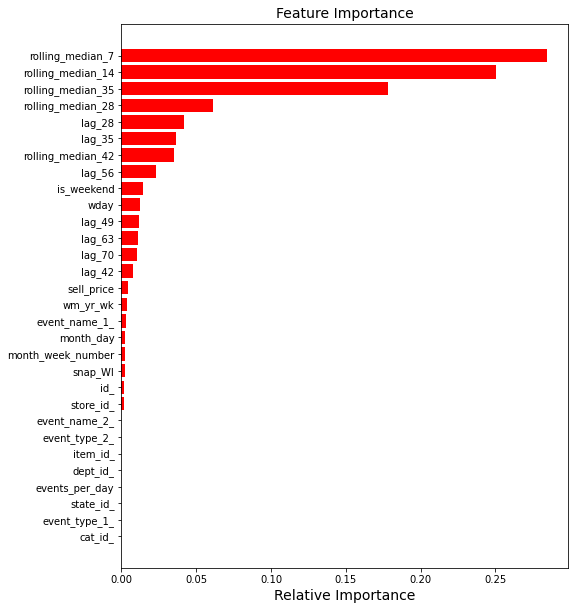

In [ ]:
features=x_train.columns
imp=xgb.feature_importances_
indices=(np.argsort(imp))[5:]
plt.figure(figsize=(8,10))
plt.title('Feature Importance',fontsize=14)
plt.barh(range(len(indices)),imp[indices],color='r')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

In [ ]:
s1=pd.DataFrame()
s2=pd.DataFrame()
#test dataset(from 1914 to 1941 days) present in sales_train_evaluation only thats why sales_train_evaluation choosen
s1['id']=sales_train_eval['id'] 
j=1
for i in range(1914,1942):
  s1['F'+str(j)]=xgb.predict(x_test[x_test['day']==(i)]) 
  j+=1
s1["id"]=s1["id"].apply(lambda x: x.replace('evaluation','validation'))
s2=s1.copy()
s2["id"]=s1["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_XGBoost_Regressor_=pd.concat([s1,s2]).reset_index().drop(['index'],axis=1)

In [ ]:
submit_XGBoost_Regressor_.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.185971,1.140580,0.642428,0.631454,0.675191,0.751295,0.752391,0.681232,0.708817,1.155353,1.137177,1.141722,1.233434,1.258822,1.141568,1.131328,1.131328,1.133404,1.714560,1.945006,1.930563,1.145249,0.668647,0.664166,0.689584,0.748832,0.733311,0.741418
1,HOBBIES_1_002_CA_1_validation,0.233632,0.207419,0.207419,0.218393,0.222274,0.289144,0.289144,0.236588,0.211164,0.211164,0.219247,0.223129,0.286253,0.286253,0.229952,0.207419,0.207419,0.207419,0.211300,0.278170,0.278170,0.221869,0.694715,0.706479,0.694715,0.698597,0.278170,0.278170
2,HOBBIES_1_003_CA_1_validation,0.931550,0.918419,1.001804,1.001804,1.024742,1.246315,1.109481,1.028367,1.016405,0.503954,0.515717,0.532770,0.671388,0.598785,0.531510,0.526047,1.108132,0.944686,1.137313,0.551848,0.525251,0.435567,0.421117,0.339020,0.628129,0.635691,0.409771,0.409771
3,HOBBIES_1_004_CA_1_validation,1.209231,1.140460,1.148543,1.884929,1.900763,1.658187,1.797427,1.907247,1.896146,1.852028,1.292263,1.333890,2.395447,2.477385,2.046085,1.979697,1.966427,1.909851,1.186673,1.425705,1.441485,1.262405,1.140607,1.140580,1.174705,1.229298,1.600159,2.183504
4,HOBBIES_1_005_CA_1_validation,1.748439,1.716696,1.762912,1.857684,1.732586,1.236521,1.466013,1.906396,1.866705,1.872722,1.301116,1.890543,2.151599,2.273579,1.958747,1.925748,1.915110,1.962260,1.984041,2.317810,2.337660,1.983696,1.385551,0.919417,0.952799,0.940144,1.607444,1.492337


In [ ]:
submit_XGBoost_Regressor_.to_csv("/content/drive//My Drive/CS-1/submit_XGBoost_Regressor_.csv",index=False)

# 5. CatBoost

* Hyperparameter - Tunning

In [ ]:
#https://catboost.ai/docs/concepts/parameter-tuning.html
for i in tqdm(range(10)):
   learning_rate=np.round(np.random.uniform(0.001,0.05),4)
   depth=np.random.randint(1,10)
   num_leaves=np.random.randint(20,200)
   #https://stackoverflow.com/questions/51111323/how-to-suppress-catboost-iteration-results
   cb=CatBoostRegressor(learning_rate=learning_rate,depth=depth,num_leaves=num_leaves,iterations=200,grow_policy='Lossguide',logging_level="Silent")
   cb.fit(x_train,y_train)
   y_pred=cb.predict(x_valid)
   print("\n\nlearning_rate: {}".format(learning_rate),"  depth: {}".format(depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))
   print("-"*150)

 10%|█         | 1/10 [23:16<3:29:28, 1396.46s/it]



learning_rate: 0.0408   depth: 4   num_leaves: 154   Rmse: 1.8369450693889864
------------------------------------------------------------------------------------------------------------------------------------------------------


 20%|██        | 2/10 [1:01:59<3:43:15, 1674.43s/it]



learning_rate: 0.0207   depth: 7   num_leaves: 94   Rmse: 1.834952620333218
------------------------------------------------------------------------------------------------------------------------------------------------------


 30%|███       | 3/10 [1:24:57<3:04:57, 1585.42s/it]



learning_rate: 0.0385   depth: 4   num_leaves: 95   Rmse: 1.8358886892132629
------------------------------------------------------------------------------------------------------------------------------------------------------


 40%|████      | 4/10 [1:43:23<2:24:09, 1441.54s/it]



learning_rate: 0.0382   depth: 3   num_leaves: 108   Rmse: 1.8435674076685038
------------------------------------------------------------------------------------------------------------------------------------------------------


 50%|█████     | 5/10 [2:02:14<1:52:22, 1348.56s/it]



learning_rate: 0.0343   depth: 3   num_leaves: 140   Rmse: 1.8457203211880906
------------------------------------------------------------------------------------------------------------------------------------------------------


 60%|██████    | 6/10 [2:46:58<1:56:36, 1749.13s/it]



learning_rate: 0.0294   depth: 8   num_leaves: 175   Rmse: 1.8627956229315934
------------------------------------------------------------------------------------------------------------------------------------------------------


 70%|███████   | 7/10 [3:00:28<1:13:21, 1467.27s/it]



learning_rate: 0.0325   depth: 2   num_leaves: 86   Rmse: 1.8697968149437918
------------------------------------------------------------------------------------------------------------------------------------------------------


 80%|████████  | 8/10 [3:08:56<39:19, 1179.67s/it]  



learning_rate: 0.0477   depth: 1   num_leaves: 119   Rmse: 1.90803982001603
------------------------------------------------------------------------------------------------------------------------------------------------------


 90%|█████████ | 9/10 [3:51:52<26:38, 1598.41s/it]



learning_rate: 0.0054   depth: 7   num_leaves: 182   Rmse: 2.1296635060236837
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [4:05:25<00:00, 1472.58s/it]



learning_rate: 0.0329   depth: 2   num_leaves: 106   Rmse: 1.8699297872043141
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
learning_rate=0.0207 
depth=7
num_leaves=94 
cb=CatBoostRegressor(learning_rate=learning_rate,depth=depth,num_leaves=num_leaves,iterations=200,grow_policy='Lossguide',logging_level="Silent")
cb.fit(x_train,y_train)
y_pred=cb.predict(x_valid)
print("learning_rate: {}".format(learning_rate),"  depth: {}".format(depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))

learning_rate: 0.0207   depth: 7   num_leaves: 94   Rmse: 1.834952620333218


In [ ]:
with open('/content/drive//My Drive/CS-1/CatBoost_model.pkl','wb') as f:
     pickle.dump(cb,f)

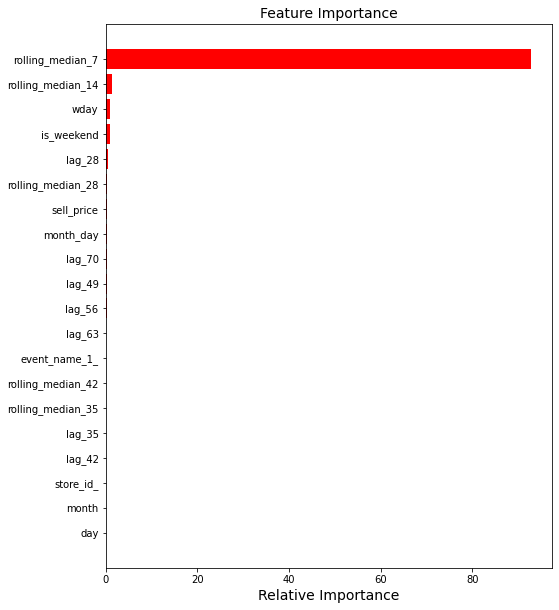

In [ ]:
features=x_train.columns
imp=cb.feature_importances_
indices=(np.argsort(imp))[15:]
plt.figure(figsize=(8,10))
plt.title('Feature Importance',fontsize=14)
plt.barh(range(len(indices)),imp[indices],color='r')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

In [ ]:
s1=pd.DataFrame()
s2=pd.DataFrame()
#test dataset(from 1914 to 1941 days) present in sales_train_evaluation only thats why sales_train_evaluation choosen
s1['id']=sales_train_eval['id'] 
j=1
for i in range(1914,1942):
  s1['F'+str(j)]=cb.predict(x_test[x_test['day']==(i)]) 
  j+=1
s1["id"]=s1["id"].apply(lambda x: x.replace('evaluation','validation'))
s2=s1.copy()
s2["id"]=s1["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_CatBoost_Regressor_=pd.concat([s1,s2]).reset_index().drop(['index'],axis=1)

In [ ]:
submit_CatBoost_Regressor_.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.115553,0.993932,0.643256,0.633981,0.678914,0.938221,0.959854,0.702209,0.699652,0.950802,0.964307,1.004312,1.256317,1.288254,1.040530,1.044786,0.998144,1.015179,1.737616,2.105759,2.083679,1.034405,0.668763,0.663144,0.676951,0.841975,0.944634,0.933502
1,HOBBIES_1_002_CA_1_validation,0.251198,0.184637,0.164520,0.283644,0.208791,0.299904,0.269726,0.238931,0.166842,0.166842,0.259221,0.202312,0.260912,0.257690,0.229761,0.166842,0.166842,0.239165,0.201391,0.249246,0.246384,0.220892,0.783006,0.782045,0.797048,0.797473,0.239304,0.212984
2,HOBBIES_1_003_CA_1_validation,0.953191,0.919769,0.927552,0.949841,0.969736,1.343855,1.269530,1.038834,1.010732,0.516739,0.540024,0.553667,0.786186,0.734388,0.563348,0.549172,0.915407,0.883667,0.969882,0.667141,0.684581,0.499628,0.481592,0.383187,0.589944,0.616221,0.509659,0.518276
3,HOBBIES_1_004_CA_1_validation,1.215107,1.084194,1.102529,1.746631,1.837462,1.857886,2.148817,2.037169,1.918875,1.752321,1.283279,1.370112,2.523807,2.549404,2.008059,1.844785,1.845883,1.834409,1.090857,1.494881,1.672567,1.243860,0.999704,1.030965,1.086649,1.139734,1.694919,2.372855
4,HOBBIES_1_005_CA_1_validation,1.751006,1.681646,1.732713,1.770161,1.728542,1.327264,1.762174,1.944530,1.875871,1.808148,1.276358,1.846499,2.263315,2.366003,1.902751,1.799877,1.811627,1.856559,1.912445,2.401971,2.442337,1.939174,1.368117,1.042999,1.044643,1.075717,1.794284,1.684448


In [ ]:
submit_CatBoost_Regressor_.to_csv("/content/drive//My Drive/CS-1/submit_CatBoost_Regressor_.csv",index=False)

# 6. LightGBM

* Hyperparameter - Tunning

In [ ]:
for i in tqdm(range(15)):
   learning_rate=np.round(np.random.uniform(0.001,0.05),4)
   max_depth=np.random.randint(5,200)
   num_leaves=np.random.randint(20,300)
   lgb=LGBMRegressor(learning_rate=learning_rate,max_depth=max_depth,num_leaves=num_leaves,n_jobs=-1,n_estimators=100)
   lgb.fit(x_train,y_train)
   y_pred=lgb.predict(x_valid)
   print("\n\nlearning_rate: {}".format(learning_rate),"  max_depth: {}".format(max_depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))
   print("-"*150)

  7%|▋         | 1/15 [05:11<1:12:45, 311.85s/it]



learning_rate: 0.0059   max_depth: 101   num_leaves: 252   Rmse: 2.518375344532912
------------------------------------------------------------------------------------------------------------------------------------------------------


 13%|█▎        | 2/15 [09:34<1:04:22, 297.14s/it]



learning_rate: 0.0258   max_depth: 186   num_leaves: 158   Rmse: 1.8418229176555687
------------------------------------------------------------------------------------------------------------------------------------------------------


 20%|██        | 3/15 [13:58<57:26, 287.19s/it]  



learning_rate: 0.034   max_depth: 66   num_leaves: 224   Rmse: 1.8299458492071858
------------------------------------------------------------------------------------------------------------------------------------------------------


 27%|██▋       | 4/15 [18:14<50:55, 277.76s/it]



learning_rate: 0.0057   max_depth: 25   num_leaves: 90   Rmse: 2.5501222931548044
------------------------------------------------------------------------------------------------------------------------------------------------------


 33%|███▎      | 5/15 [22:34<45:23, 272.32s/it]



learning_rate: 0.0285   max_depth: 23   num_leaves: 177   Rmse: 1.835297115093587
------------------------------------------------------------------------------------------------------------------------------------------------------


 40%|████      | 6/15 [25:40<36:57, 246.44s/it]



learning_rate: 0.0459   max_depth: 49   num_leaves: 41   Rmse: 1.8449141899152701
------------------------------------------------------------------------------------------------------------------------------------------------------


 47%|████▋     | 7/15 [29:53<33:08, 248.58s/it]



learning_rate: 0.0195   max_depth: 155   num_leaves: 115   Rmse: 1.8861308548710447
------------------------------------------------------------------------------------------------------------------------------------------------------


 53%|█████▎    | 8/15 [34:04<29:03, 249.13s/it]



learning_rate: 0.0449   max_depth: 123   num_leaves: 227   Rmse: 1.8449907101422298
------------------------------------------------------------------------------------------------------------------------------------------------------


 60%|██████    | 9/15 [37:08<22:58, 229.67s/it]



learning_rate: 0.0152   max_depth: 5   num_leaves: 261   Rmse: 1.9837853843809499
------------------------------------------------------------------------------------------------------------------------------------------------------


 67%|██████▋   | 10/15 [41:41<20:14, 242.84s/it]



learning_rate: 0.0288   max_depth: 37   num_leaves: 245   Rmse: 1.8351218826640192
------------------------------------------------------------------------------------------------------------------------------------------------------


 73%|███████▎  | 11/15 [45:41<16:07, 241.81s/it]



learning_rate: 0.0481   max_depth: 114   num_leaves: 182   Rmse: 1.8549204569780375
------------------------------------------------------------------------------------------------------------------------------------------------------


 80%|████████  | 12/15 [49:56<12:17, 245.92s/it]



learning_rate: 0.0278   max_depth: 189   num_leaves: 158   Rmse: 1.8377289874613314
------------------------------------------------------------------------------------------------------------------------------------------------------


 87%|████████▋ | 13/15 [53:29<07:51, 235.94s/it]



learning_rate: 0.0445   max_depth: 121   num_leaves: 84   Rmse: 1.8448974192855276
------------------------------------------------------------------------------------------------------------------------------------------------------


 93%|█████████▎| 14/15 [57:20<03:54, 234.41s/it]



learning_rate: 0.029   max_depth: 140   num_leaves: 94   Rmse: 1.8365709725245778
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 15/15 [1:01:17<00:00, 245.15s/it]



learning_rate: 0.0308   max_depth: 98   num_leaves: 118   Rmse: 1.833985237661415
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
learning_rate=0.034 
max_depth=66 
num_leaves=224 
lgb=LGBMRegressor(learning_rate=learning_rate,max_depth=max_depth,num_leaves=num_leaves,n_jobs=-1,n_estimators=100)
lgb.fit(x_train,y_train)
y_pred=lgb.predict(x_valid)
print("learning_rate: {}".format(learning_rate),"  max_depth: {}".format(max_depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))

learning_rate: 0.034   max_depth: 66   num_leaves: 224   Rmse: 1.8299458492071858


In [ ]:
with open('/content/drive//My Drive/CS-1/lgb_model.pkl','wb') as f:
     pickle.dump(lgb,f)

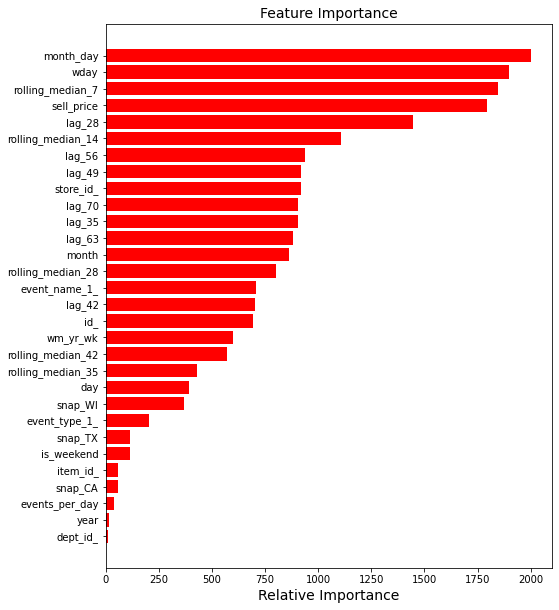

In [ ]:
features=x_train.columns
imp=lgb.feature_importances_
indices=(np.argsort(imp))[5:]
plt.figure(figsize=(8,10))
plt.title('Feature Importance',fontsize=14)
plt.barh(range(len(indices)),imp[indices],color='r')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

In [ ]:
s1=pd.DataFrame()
s2=pd.DataFrame()
#test dataset(from 1914 to 1941 days) present in sales_train_evaluation only thats why sales_train_evaluation choosen
s1['id']=sales_train_eval['id'] 
j=1
for i in range(1914,1942):
  s1['F'+str(j)]=lgb.predict(x_test[x_test['day']==(i)]) 
  j+=1
s1["id"]=s1["id"].apply(lambda x: x.replace('evaluation','validation'))
s2=s1.copy()
s2["id"]=s1["id"].apply(lambda x: x.replace('validation','evaluation'))
submit_LGBM_Regressor_=pd.concat([s1,s2]).reset_index().drop(['index'],axis=1)

In [ ]:
submit_LGBM_Regressor_.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.119852,1.004083,0.621321,0.619367,0.662414,0.953698,0.945955,0.694231,0.651312,0.938497,0.986196,1.010586,1.252667,1.256220,1.059940,1.065216,1.010111,1.017906,1.733666,2.123730,2.088054,1.047366,0.645954,0.634444,0.664574,0.902673,0.931484,0.949897
1,HOBBIES_1_002_CA_1_validation,0.277386,0.201086,0.164073,0.319285,0.231003,0.317464,0.296929,0.270623,0.165277,0.165277,0.303674,0.224398,0.292420,0.289503,0.260061,0.165277,0.165277,0.268440,0.219431,0.274338,0.262873,0.239372,0.813375,0.813375,0.816284,0.816284,0.258900,0.227870
2,HOBBIES_1_003_CA_1_validation,0.975054,0.946946,0.945607,0.977262,0.990626,1.317258,1.267077,1.079568,1.041410,0.546083,0.543074,0.574422,0.807435,0.762794,0.581037,0.564713,0.917355,0.905444,0.965162,0.712861,0.733169,0.514879,0.513349,0.390051,0.571779,0.588005,0.516895,0.529492
3,HOBBIES_1_004_CA_1_validation,1.248924,1.088253,1.100270,1.757304,1.829056,1.917118,2.114546,2.013219,1.910499,1.749224,1.276837,1.373562,2.480753,2.516382,2.008433,1.830690,1.856665,1.814833,1.118688,1.486043,1.588841,1.272243,1.018016,1.049784,1.131716,1.180028,1.592603,2.313752
4,HOBBIES_1_005_CA_1_validation,1.741878,1.686405,1.763381,1.792825,1.720316,1.334280,1.811203,2.031866,1.961079,1.831707,1.281079,1.891710,2.269708,2.355058,1.935242,1.817016,1.830360,1.865898,1.924800,2.390241,2.405216,1.963858,1.333160,1.042549,1.052399,1.105436,1.864449,1.653745


In [ ]:
submit_LGBM_Regressor_.to_csv("/content/drive//My Drive/CS-1/submit_LGBM_Regressor_.csv",index=False)

#Model Comparison

In [ ]:
pip install tabletext   

  Created wheel for tabletext: filename=tabletext-0.1-cp37-none-any.whl size=6024 sha256=e0eb8f016d2c75c28bb4a1c030afe05f65151907f8748acb25bb28f130acffbd
  Stored in directory: /root/.cache/pip/wheels/63/15/d8/897b137f43975c4f5f49139be65fee6dbeab6a3f88c1838f66
Successfully built tabletext


In [ ]:
#Refernece taken from : https://pypi.org/project/tabletext/
import tabletext

s = [['No.','Model Name','RMSE'],
        ['1','Moving Average',3.2802],
        ['2','Linear Regression',1.8829],
        ['3','Decision Tree Regressor',1.8667],
        ['4','Random Forest Regressor',1.8512],
        ['5','XGBoost Regressor',1.8507],
        ['6','CatBoost Regressor',1.8349],
        ['7','LightGBM Regressor',1.8299]
      ]
print(tabletext.to_text(s))

┌─────┬─────────────────────────┬────────┐
│ No. │ Model Name              │ RMSE   │
├─────┼─────────────────────────┼────────┤
│ 1   │ Moving Average          │ 3.2802 │
├─────┼─────────────────────────┼────────┤
│ 2   │ Linear Regression       │ 1.8829 │
├─────┼─────────────────────────┼────────┤
│ 3   │ Decision Tree Regressor │ 1.8667 │
├─────┼─────────────────────────┼────────┤
│ 4   │ Random Forest Regressor │ 1.8512 │
├─────┼─────────────────────────┼────────┤
│ 5   │ XGBoost Regressor       │ 1.8507 │
├─────┼─────────────────────────┼────────┤
│ 6   │ CatBoost Regressor      │ 1.8349 │
├─────┼─────────────────────────┼────────┤
│ 7   │ LightGBM Regressor      │ 1.8299 │
└─────┴─────────────────────────┴────────┘


# Kaggle Score

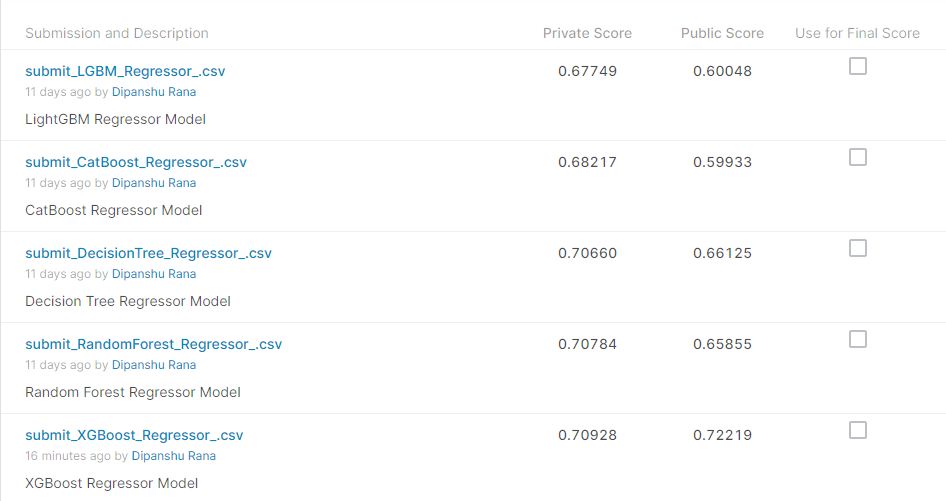

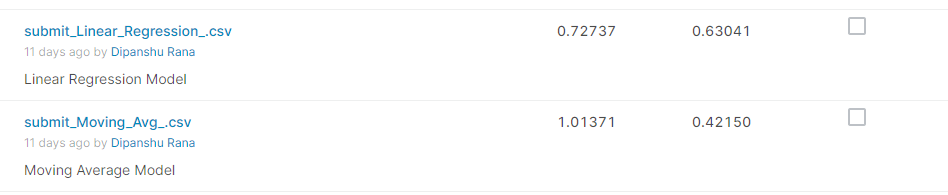